# BBC News Classification Project

The goal of this notebook is to classify BBC news articles into one of five categories: business, entertainment, politics, sport, and tech. The dataset is from [Kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

We are going to use a supervised learning model and compare it to a Matrix Factorization model.

## Setup

In [26]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

In [17]:
sns.set_style('dark')
sns.set_palette('muted', color_codes=True)  
np.random.seed(42)


In [18]:
os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
!kaggle competitions download -c learn-ai-bbc -p data 
with zipfile.ZipFile('data\learn-ai-bbc.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)


## EDA

The data consist of 1490 rows, each row representing a news article. There are 3 columns: ArticleId, Text and Category.

In [19]:
df_train_news = pd.read_csv('data\BBC News Train.csv')
df_train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [20]:
df_train_news.sample(10)

,ArticleId,Text,Category
941,2160,wal-mart is sued over rude lyrics the parents ...,entertainment
297,1360,howard taunts blair over splits tony blair s f...,politics
271,302,fox attacks blair s tory lies tony blair lie...,politics
774,864,online commons to spark debate online communit...,tech
420,2184,piero gives rugby perspective bbc sport unveil...,tech
1090,1322,us retail sales surge in december us retail sa...,business
427,930,casual gaming to take off games aimed at ca...,tech
1393,1314,ring of fire hit co-writer dies merle kilgore ...,entertainment
231,140,rich grab half colombia poor fund half of the ...,business
1489,538,santy worm makes unwelcome visit thousands of ...,tech


We are going to change the index to ArticleId and then look at the distribution of the categories.

In [21]:
df_train_news.set_index('ArticleId', inplace=True)
df_train_news['Category'] = df_train_news['Category'].str.capitalize()

e:\Documents\BBC News-Classification\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Documents\BBC News-Classification\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Documents\BBC News-Classification\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.0, 400.0)

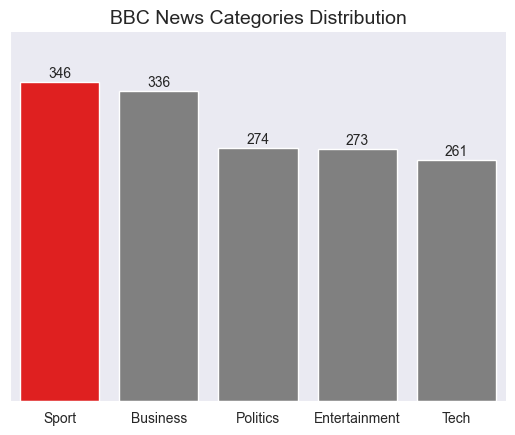

In [22]:
data = df_train_news['Category'].value_counts()
colors = ['grey' if (x < max(data)) else 'red' for x in data.values]
fig = sns.barplot(x=data.index, y=data.values, palette=colors)

sns.despine()
plt.title('BBC News Categories Distribution', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=True)       
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+5,s='{:.0f}'.format(height), ha='center')
plt.ylim(0,400)

As we can see, the categories are somewhat evenly distributed.

Let's take a look at a random article.

In [23]:
df_train_news.sample(1, random_state=42)

,Text,Category
ArticleId,,
2160,wal-mart is sued over rude lyrics the parents ...,Entertainment


In [31]:
df_train_news['Text'][2160]

'wal mart is sued over rude lyrics the parents of a    year old girl are suing us supermarket giant wal mart over a cd by rock group evanescence that contains swear words  the lawsuit filed in washington county alleges wal mart deceived customers by not putting warning labels on the cover  trevin skeens alleges wal mart knew of the offending word because it had censored it on its music sales website  wal mart said it was investigating the claims but had no plans to pull the cd  wal mart has a policy of not stocking cds which carry parental advisory labels  mr skeens said he bought the anywhere but home cd for his daughter and was shocked to hear the swearing when it was played in their car   i don t want any other families to get this expecting it to be clean  it needs to be removed from the shelves to prevent other children from hearing it  said mr skeens of brownsville  the lawsuit seeks to force wal mart to censor the music or remove it from its stores in maryland  it also seeks dam

There is some cleaning to do, for example removing punctuation, numbers, etc.

Now, since the input data is text, we first need to clean it up for NLP, we are going to follow some steps recommended by [this article](https://www.analyticsvidhya.com/blog/2021/05/natural-language-processing-step-by-step-guide/).

In [29]:
df_train_news['Text'] = df_train_news['Text'].apply(lambda x: re.sub("[^a-zA-Z]", ' ',x))

First we are going to remove stopwords, which are words that in general don't add much meaning to the text, such as "the", "a", "an", etc.

In [32]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cozie\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
